In [1]:
import xarray as xr
import fsspec
import os
from vcm.select import RegionOfInterest

kg_m2s_to_mm_day = (1e3 * 86400) / 997.0
kg_m2_to_mm  = 1000. / 997.0

import xarray as xr
import numpy as np
import fsspec
import intake
from vcm.catalog import catalog 
import fv3viz
import cftime
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import timedelta
import seaborn as sns
import vcm


slmsk = catalog["landseamask/c48"].read()
grid = catalog["grid/c48"].read()

figsize=(12,4)
col_wrap = 2
rename_dims = {"grid_xt": "x", "grid_yt": "y", "grid_y": "y_interface", "grid_x": "x_interface"}


In [7]:
fv3viz.use_colorblind_friendly_style()

In [25]:
from cycler import cycler
import matplotlib as mpl

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

colorlist = ['black', ] + default_colors
#colorlist = default_colors

linestyle_list = ["--"]+ ["-" for v in colorlist[1:]]


cmap = mpl.colors.ListedColormap(colorlist)
custom_cycler = cycler(color=cmap.colors, linestyle=linestyle_list) #or simply color=colorlist

#custom_cycler = cycler(color=cmap.colors, )

cmap_no_verif = mpl.colors.ListedColormap(colorlist[1:])
custom_cycler_no_verif = cycler(color=cmap_no_verif.colors, linestyle=linestyle_list[1:]) #or simply color=colorlist


In [3]:
experiments = {
    "Baseline": "gs://vcm-ml-experiments/n2f-pire-sfc-updates/2022-01-10/baseline-seaice-prescribed",
    "ML ensemble": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-09/decrease-rad-lr-updated-rad-flux-ensemble",
    "ML seed 0": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-0",
    "ML seed 1": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-1",
    "ML seed 2": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-2",
    "ML seed 3": "gs://vcm-ml-experiments/n2f-pire-stable-ml/2022-07-08/decrease-rad-lr-updated-rad-flux-seed-3"

}

In [10]:
diags_vars = [
    "pwat_zonal_mean_value",
    "pratesfc_zonal_mean_value", 
    "lhtflsfc_zonal_mean_value", 
    "shtflsfc_zonal_mean_value",
    "total_precip_to_surface_zonal_and_time_mean",
    "pwat_zonal_and_time_mean",
    "total_precip_to_surface_zonal_mean_value",
    "pwat_zonal_mean_value",
    "vgrd10m_zonal_and_time_mean",
    "vgrd10m_zonal_mean_value",
    "vgrd850_zonal_and_time_mean",
    "vgrd850_zonal_mean_value"
]
diags, labels = [], []

for experiment, prog_run in experiments.items():
    with fsspec.open(os.path.join(prog_run, "fv3gfs_run_diagnostics", "diags.nc")) as f:
        diags.append(xr.open_dataset(f)[diags_vars].load())
    labels.append(experiment)
ds_diags = xr.concat(diags, dim=pd.Index(labels, name="experiment"))

In [4]:
dyn_verif = catalog["2020_1yr_pire_dyn"].to_dask().rename({"grid_xt": "x", "grid_yt": "y"})
physics_verif = catalog["2020_1yr_pire_physics"].to_dask().rename({"grid_xt": "x", "grid_yt": "y"}) 

In [5]:
verif_time_mean = xr.merge([
    physics_verif[["PRATEsfc_coarse"]].mean("time"),
    dyn_verif["PWAT"].mean("time")
])

verif = vcm.zonal_average_approximate(
    grid.lat,
    verif_time_mean
).rename(
    {
        "PRATEsfc_coarse": "total_precip_to_surface_zonal_and_time_mean",
        "PWAT": "pwat_zonal_and_time_mean",
        "lat": "latitude"
    }
) \
.expand_dims("experiment") \
.assign_coords({"experiment": ["verification"]})
verif["total_precip_to_surface_zonal_and_time_mean"] = verif["total_precip_to_surface_zonal_and_time_mean"] * kg_m2s_to_mm_day
verif["pwat_zonal_and_time_mean"] = verif["pwat_zonal_and_time_mean"]  * kg_m2_to_mm

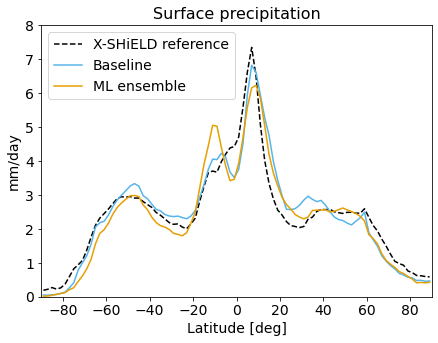

In [51]:

fig = plt.figure(figsize=(7,5))
ax = plt.gca()

ax.set_prop_cycle(custom_cycler)

precip_ = verif.merge(ds_diags) \
    .sel(experiment=["verification", "Baseline", "ML ensemble"] ) \
    ["total_precip_to_surface_zonal_and_time_mean"] 


lat = precip_.latitude.values

for exp, label in zip(["verification", "Baseline", "ML ensemble"], ["X-SHiELD reference", "Baseline", "ML ensemble"]):
    ax.plot(precip_.latitude.values, precip_.sel(experiment=exp).values, label=label)

plt.title("Surface precipitation", fontsize=16)
plt.xlabel("Latitude [deg]", fontsize=14)
plt.ylabel("mm/day", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.xlim(-90, 90)
plt.ylim(0, 8)


plt.legend(loc='upper left', fontsize=14)
plt.savefig("figures/pdf/prognostic_zonal_time_mean_precip.pdf", dpi=150)
plt.savefig("figures/png/prognostic_zonal_time_mean_precip.png", dpi=150)

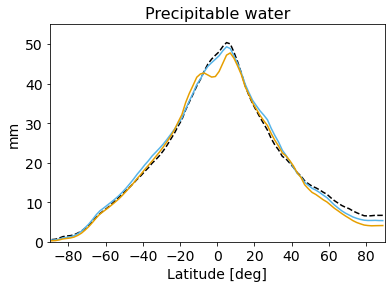

In [54]:
fig = plt.figure()
ax = plt.gca()

ax.set_prop_cycle(custom_cycler)

pwat_ = verif.merge(ds_diags) \
    .sel(experiment=["verification", "Baseline", "ML ensemble"] ) \
    ["pwat_zonal_and_time_mean"]* kg_m2_to_mm
lat = pwat_.latitude.values

for exp, label in zip(["verification", "Baseline", "ML ensemble"], ["X-SHiELD reference", "Baseline", "ML ensemble"]):
    ax.plot(pwat_.latitude.values, pwat_.sel(experiment=exp).values, label=label)


plt.title("Precipitable water", fontsize=16)
plt.xlabel("Latitude [deg]", fontsize=14)
plt.ylabel("mm", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(-90, 90)
plt.ylim(0, 55)

#plt.legend(loc='upper left', fontsize=14)
plt.savefig("figures/pdf/prognostic_zonal_time_mean_pwat.pdf", dpi=150)
plt.savefig("figures/png/prognostic_zonal_time_mean_pwat.png", dpi=150)

In [58]:
ds_diags["vgrd850_zonal_mean_value"].experiment

<xarray.DataArray 'experiment' (experiment: 6)>
array(['Baseline', 'ML ensemble', 'ML seed 0', 'ML seed 1', 'ML seed 2',
       'ML seed 3'], dtype=object)
Coordinates:
  * experiment  (experiment) object 'Baseline' 'ML ensemble' ... 'ML seed 3'